## Setup and Library Imports

Essential libraries for data manipulation, deep learning, evaluation and visualization.

In [8]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import joblib

Random seeds are set to ensure reproducibility of results.

In [9]:
seed = 99
random.seed(seed)
np.random.seed(42)
tf.random.set_seed(42)

## Dataset

**Air Quality Dataset**

Kaggle link:  https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set

This dataset contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. 

**Content**

The dataset contains one csv file the following features:

- 0 Date	(DD/MM/YYYY)
- 1 Time	(HH.MM.SS)
- 2 True hourly averaged concentration CO in mg/m^3  (reference analyzer)
- 3 PT08.S1 (tin oxide)  hourly averaged sensor response (nominally  CO targeted)	
- 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
- 5 True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer)
- 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
- 7 True hourly averaged NOx concentration  in ppb (reference analyzer)
- 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
- 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
- 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
- 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
- 12 Temperature in Â°C	
- 13 Relative Humidity (%) 	
- 14 AH Absolute Humidity


**Acknowledgements**

This Dataset is taken from the official UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/index.php

## Data Organization and Preprocessing

This cell organizes and preprocesses image data for a machine learning project:
- Path Definitions: Specifies paths for raw and processed data directories.
- Folder Creation: Generates necessary subdirectories within the processed data path for training, validation, and testing datasets, categorized by labels ('Uninfected' and 'Parasitized').
- Image Listing: Lists all images in the 'Uninfected' and 'Parasitized' categories from the raw data directory.
- Data Splitting: Utilizes an 80-10-10 split strategy to divide images into training, validation, and test sets. The train_test_split function from Scikit-learn is used to ensure reproducibility with a fixed random seed.
- File Copying: Copies images into their respective directories based on the split, ensuring that each dataset is organized correctly for model training and evaluation.

### **Loading Raw Data**

Definition of the file path and importation of the raw data:

- **Define Paths**: We specify the path to the directory containing the data files. The `data_path` variable is set to point to the `raw` folder within the `data` directory.
- **Import Data**: We read the `AirQuality.csv` file using `pandas`. The file is located in the `raw` data directory, and we specify the separator as a semicolon (`;`) and the decimal point as a comma (`,`), which is common in European data formats. The data is then loaded into the `raw_data` DataFrame for further processing and analysis.

In [10]:
# Define paths
data_path = os.path.join('..', 'data', 'raw')

# Import data
raw_data = pd.read_csv(os.path.join(data_path, 'AirQuality.csv'), sep=';', decimal=',')
raw_data

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning

We see that there are two extra columns that do not provide any information. In fact, they are not even named in the dataset documentation. In addition, there are several values with NaN, plus the documentation says that the missing values have been labeled with (-200). Therefore, we treat both options as NaN. We see how present they are.

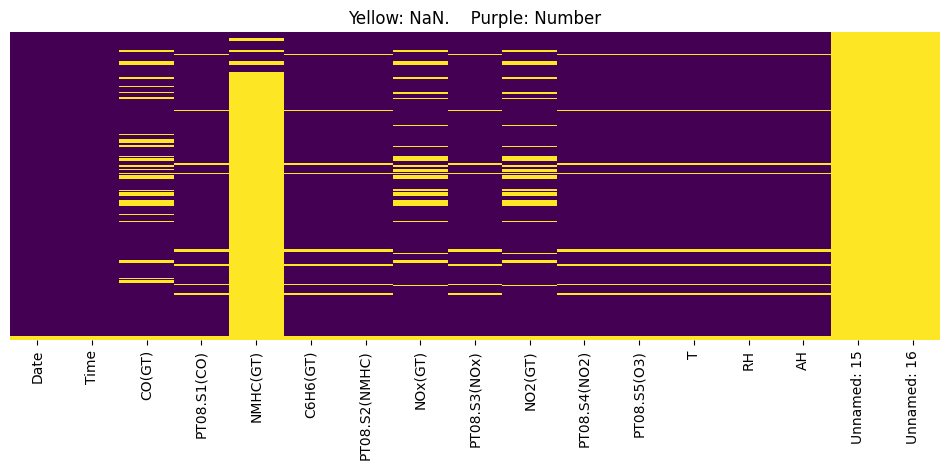

In [11]:
raw_data = raw_data.replace(to_replace=-200, value=np.nan)
plt.figure(figsize=(12, 4))
plt.title('Yellow: NaN.    Purple: Number')
sns.heatmap(raw_data.isna(), yticklabels=False, cmap='viridis', cbar=False)
plt.show()

Due to the large number of NaNs, the columns **NMHC(GT)**, **Unnamed: 15**, **Unnamed: 16** are deleted.

In addition, it is important to remove rows with NaNs in the Date column. All variables have NaNs in those rows.

In [ ]:
# Elimination of variables without information
try:
    raw_data = raw_data.drop(['NMHC(GT)', 'Unnamed: 15', 'Unnamed: 16'], axis=1)
except Exception:
    pass
raw_data = raw_data.dropna(subset='Date')
raw_data

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


Next, a Timestamp variable is created by combining the Date and Time columns. The latter are deleted.

In [13]:
raw_data['Date'] = pd.to_datetime(raw_data.Date + raw_data.Time, format="%d/%m/%Y%H.%M.%S")
raw_data = raw_data.drop('Time', axis=1).rename(columns={'Date': 'Timestamp'})
raw_data

,Timestamp,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,2005-04-04 13:00:00,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


Finally, we can interpolate the intermediate NaN values or directly substitute them by the mean of each column

In [14]:
raw_data_interp = raw_data.interpolate()
raw_data_avg = pd.concat([raw_data.Timestamp, raw_data.drop('Timestamp', axis=1).fillna(raw_data.drop('Timestamp', axis=1).mean(0))], axis=1)

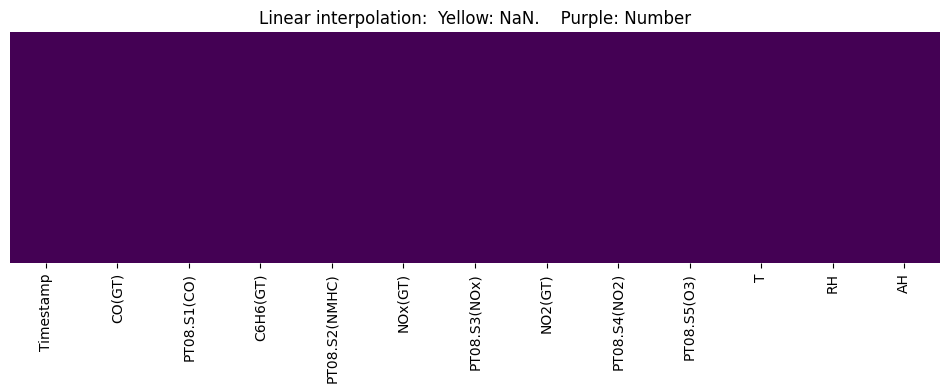

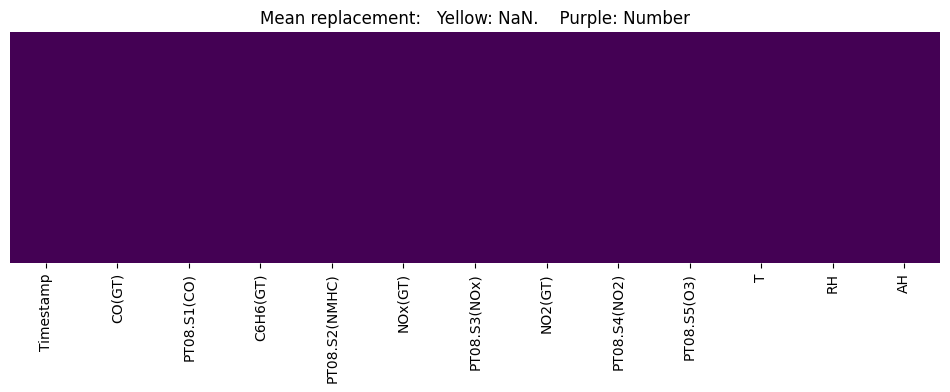

In [15]:
plt.figure(figsize=(12, 3))
plt.title('Linear interpolation:  Yellow: NaN.    Purple: Number')
sns.heatmap(raw_data_interp.isna(), yticklabels=False, cmap='viridis', cbar=False)
plt.show()

plt.figure(figsize=(12, 3))
plt.title('Mean replacement:   Yellow: NaN.    Purple: Number')
sns.heatmap(raw_data_interp.isna(), yticklabels=False, cmap='viridis', cbar=False)
plt.show()

Ya eliminados los NaN, podemos ver la cantidad de outliers que tienen los datos mediante un gráfico boxplot

### **Outliers Visualization**

Boxplot to visualize the distribution of the data. There are quite a few outliers, so it will be necessary to keep an eye on them in case they affect the accuracy of the regression model.

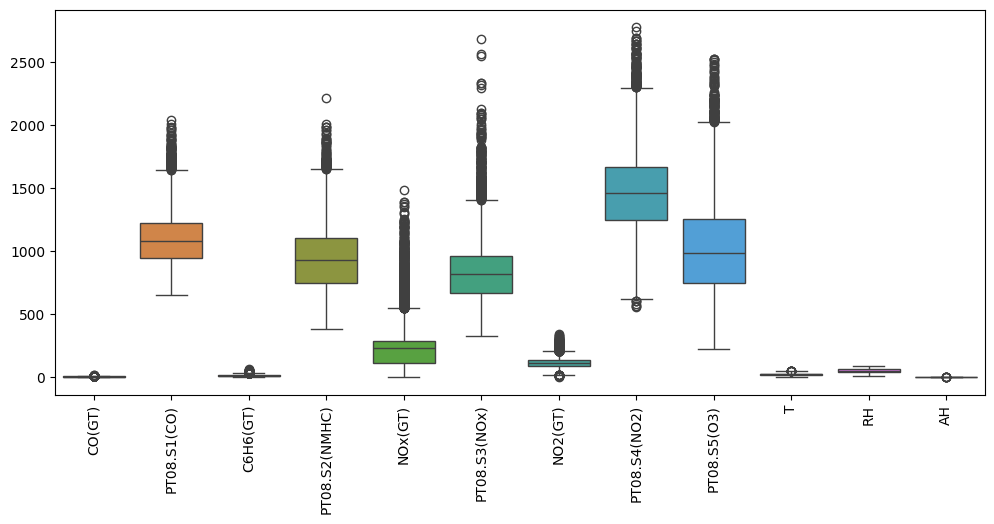

In [ ]:
# Plotting a boxplot
plt.figure(figsize=(12, 5))
sns.boxplot(data=raw_data_avg)
plt.xticks(rotation='vertical')
plt.show()

### **Data Types Visualization**

Let's see the types of variables in the dataset in case we need to treat categorical variables. Salvo el Timestamp, todas las variables son numéricas

In [17]:
raw_data_interp.dtypes

Timestamp        datetime64[ns]
CO(GT)                  float64
PT08.S1(CO)             float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

### **Feature Engineering via Correlation matrix**

Now, we can perform a correlation analysis between the different variables in order to see which ones will be useful to predict the target variable.

This target variable is going to be NO2(GT), i.e. True hourly averaged NO2 concentration in microg/m^3

- **Heatmap Visualization**: 
  - We create a heatmap to display the correlation matrix of the dataset (excluding the first column - Timestamp).
  - The `viridis` colormap is used for a visually appealing gradient.
  - Correlation values are annotated on the heatmap for clarity, helping to identify relationships between variables.

- **Feature Selection**:
Given the correlations with the target variable, it seems a good option to use the first 5 variables as predictor variables, in addition to the target variable itself.
  - We extract specific columns from `raw_data_interp` into a new DataFrame `df`.
  - The selected columns include `Timestamp`, `CO(GT)`, `PT08.S1(CO)`, `C6H6(GT)`, `PT08.S2(NMHC)`, `NOx(GT)`, and `NO2(GT)`.
  - This subset focuses on key pollutants and sensor readings for further analysis.

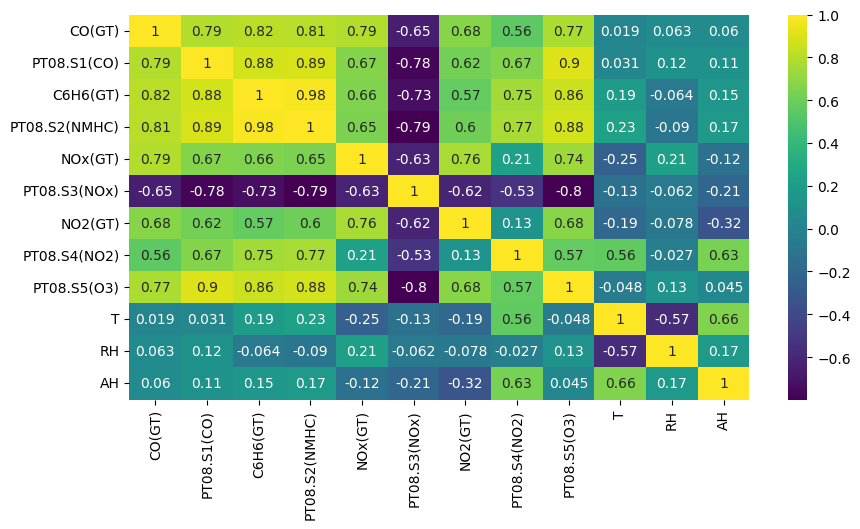

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(raw_data_interp.iloc[:, 1:].corr(), cmap='viridis', annot=True)
plt.show()

In [19]:
df = raw_data_interp[['Timestamp', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)']]
df

,Timestamp,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),NO2(GT)
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,113.0
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,92.0
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,114.0
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,122.0
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,116.0
...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,472.0,190.0
9353,2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,353.0,179.0
9354,2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,293.0,175.0
9355,2005-04-04 13:00:00,2.1,1003.0,9.5,961.0,235.0,156.0


We check the seasonality of the target variable by representing the data series

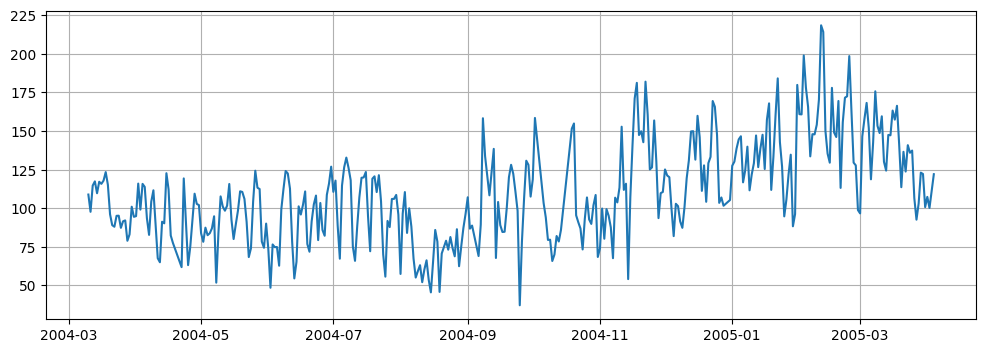

In [20]:
target = 'NO2(GT)'
aux = raw_data_interp.set_index('Timestamp').resample('1d').mean().dropna().reset_index()  # Smoothed time series
plt.figure(figsize=(12, 4))
plt.plot(aux.Timestamp, aux[target])
plt.grid()
plt.show()

## Data Processing

### **Data Splitting and Normalization**

This section focuses on splitting the dataset into training, validation, and test sets, followed by normalization:

- **Data Splitting**:
  - The dataset `df` is split into three parts: `train_df`, `val_df`, and `test_df`.
  - **Training Set**: Comprises 80% of the data.
  - **Validation Set**: Contains 10% of the data.
  - **Test Set**: Consists of the remaining 10% of the data.
  - This division helps in training the model, tuning hyperparameters, and evaluating performance.
  - Split is made sequential (no shuffle) since we will want to test the model on the most recent data.

- **Normalization Process**:
  - We define a function `get_norm_bounds` to calculate the 1st and 99th percentiles for each numeric column (excluding `Timestamp`) in the training set. These percentiles serve as lower and upper bounds for normalization.
  - The function `normalize_values` normalizes the numeric columns using these bounds to scale the data between 0 and 1. The `Timestamp` column remains unchanged.
  - The normalization is applied to `train_df`, `val_df`, and `test_df`, resulting in `train_norm`, `val_norm`, and `test_norm` respectively. This ensures that all datasets are on a comparable scale for modeling.
  - Bounds are saved to be used in prediction stage.

In [ ]:
train_df, val_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):int(len(df) * 0.9)], df.iloc[int(len(df) * 0.9):]

In [22]:
def get_norm_bounds(df):
    # Calculate 1st and 99th percentiles for each numeric column (without Timstamp)
    lower_bound = df.iloc[:, 1:].quantile(0.01)
    upper_bound = df.iloc[:, 1:].quantile(0.99)

    return lower_bound, upper_bound


def normalize_values(df, lower_bound, upper_bound):
    # Normalize using the limits of the numeric columns
    normalized_df = (df.iloc[:, 1:] - lower_bound) / (upper_bound - lower_bound)
    normalized_df = pd.concat([df.Timestamp, normalized_df], axis=1)

    return normalized_df

lower_bound, upper_bound = get_norm_bounds(train_df)
train_norm = normalize_values(train_df, lower_bound, upper_bound)
val_norm = normalize_values(val_df, lower_bound, upper_bound)
test_norm = normalize_values(test_df, lower_bound, upper_bound)

joblib.dump(lower_bound, os.path.join('..', 'data', 'interim', 'bounds', 'lower_bound.pkl'))
joblib.dump(upper_bound, os.path.join('..', 'data', 'interim', 'bounds', 'upper_bound.pkl'))

['..\\data\\interim\\bounds\\upper_bound.pkl']

### **Sequence Creation for Time Series Forecasting**

This section details the preparation of input and output sequences for time series forecasting:

- **Parameters**:
  - **N (Input Timesteps)**: The number of past timesteps used as input for each prediction, set to 500.
  - **Forecast Horizon**: The number of future values to predict, set to 100.

- **Sequence Creation Function**:
  - The `create_sequences` function generates sequences from the normalized datasets.
  - **Inputs (X)**: For each sequence, we take `N` timesteps of data, excluding the `Timestamp`.
  - **Outputs (y)**: The target values are the next `forecast_horizon` values of the `NO2(GT)` column, which is the last column in the dataset.
  
- **Data Preparation**:
  - Sequences are created for training (`X_train`, `y_train`), validation (`X_val`, `y_val`), and test (`X_test`, `y_test`) datasets.
  - This setup is crucial for training models to predict future values based on historical data.

In [ ]:
N = 500  # Number of input timesteps
forecast_horizon = 100  # Number of values to predict

# Create input and output windows
def create_sequences(data, N, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - N - forecast_horizon + 1):
        X.append(data.iloc[i:i + N, 1:])  # We no longer take into account the timestamp
        y.append(data.iloc[i + N:i + N + forecast_horizon, -1])  # NO2(GT) is the last column
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_norm, N, forecast_horizon)
X_val, y_val = create_sequences(val_norm, N, forecast_horizon)
X_test, y_test = create_sequences(test_norm, N, forecast_horizon)

## **LSTM Model for Time Series Forecasting**

Setup and training of an LSTM model for predicting future values:

- **Model Architecture**:
  - A Sequential model is constructed using TensorFlow Keras.
  - **Input Layer**: Accepts sequences with dimensions based on the training data.
  - **LSTM Layer**: An LSTM layer with units equal to the `forecast_horizon` is used to capture temporal dependencies. The `return_sequences` parameter is set to `False`, indicating that only the final output is needed.
  - **Dropout Layer**: A dropout rate of 0.3 is applied to prevent overfitting by randomly setting a fraction of input units to zero during training.
  - **Dense Layer**: Outputs predictions for the forecast horizon.

- **Compilation**:
  - The model is compiled with the Adam optimizer and mean squared error (MSE) loss function, suitable for regression tasks.

- **Training**:
  - The model is trained for up to 20 epochs with a batch size of 32.
  - An early stopping callback monitors validation loss and stops training if it does not improve for two consecutive epochs, helping to avoid overfitting.
  
- **Model Saving**:
  - After training, the model is saved to the specified directory for future use or evaluation.

In [141]:
# LSTM Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((X_train.shape[1], X_train.shape[2])),
    # tf.keras.layers.LSTM(200, return_sequences=True),
    tf.keras.layers.LSTM(forecast_horizon, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(forecast_horizon)
])
model.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss='mse')

# Training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])
model.save(os.path.join('..', 'models', 'lstm_model.keras'))

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - loss: 0.1289 - val_loss: 0.1480
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - loss: 0.0519 - val_loss: 0.1187
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - loss: 0.0471 - val_loss: 0.1128
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - loss: 0.0449 - val_loss: 0.1076
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - loss: 0.0434 - val_loss: 0.1051
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - loss: 0.0415 - val_loss: 0.1002
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 27s 127ms/step - loss: 0.0385 - val_loss: 0.0949
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - loss: 0.0358 - val_loss: 0.0953
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - loss: 0.0341 - val_loss: 0.0984
Epoch 9: early stopping


### **LSTM Predictions vs. Actual Values**

Visualization of the LSTM model's predictions compared to actual values:

- **Prediction Generation**:
  - The model generates predictions for the test dataset (`X_test`), stored in `lstm_pred`.

- **Visualization Parameters**:
  - **Number of Plots**: We visualize 10 sets of predictions.
  - **Grid Layout**: The plots are arranged in a grid with 2 columns and a calculated number of rows to accommodate all plots.

- **Plotting**:
  - For each selected prediction, we plot the actual and predicted values over the forecast horizon.
  - **Forecast Steps**: Represented on the x-axis, indicating the prediction timestep.
  - **Actual Values**: Plotted in blue, providing a baseline for comparison.
  - **Predicted Values**: Plotted in red with a dashed line, showing the LSTM model's forecast.
  - Each subplot is titled to indicate which prediction is being compared.

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


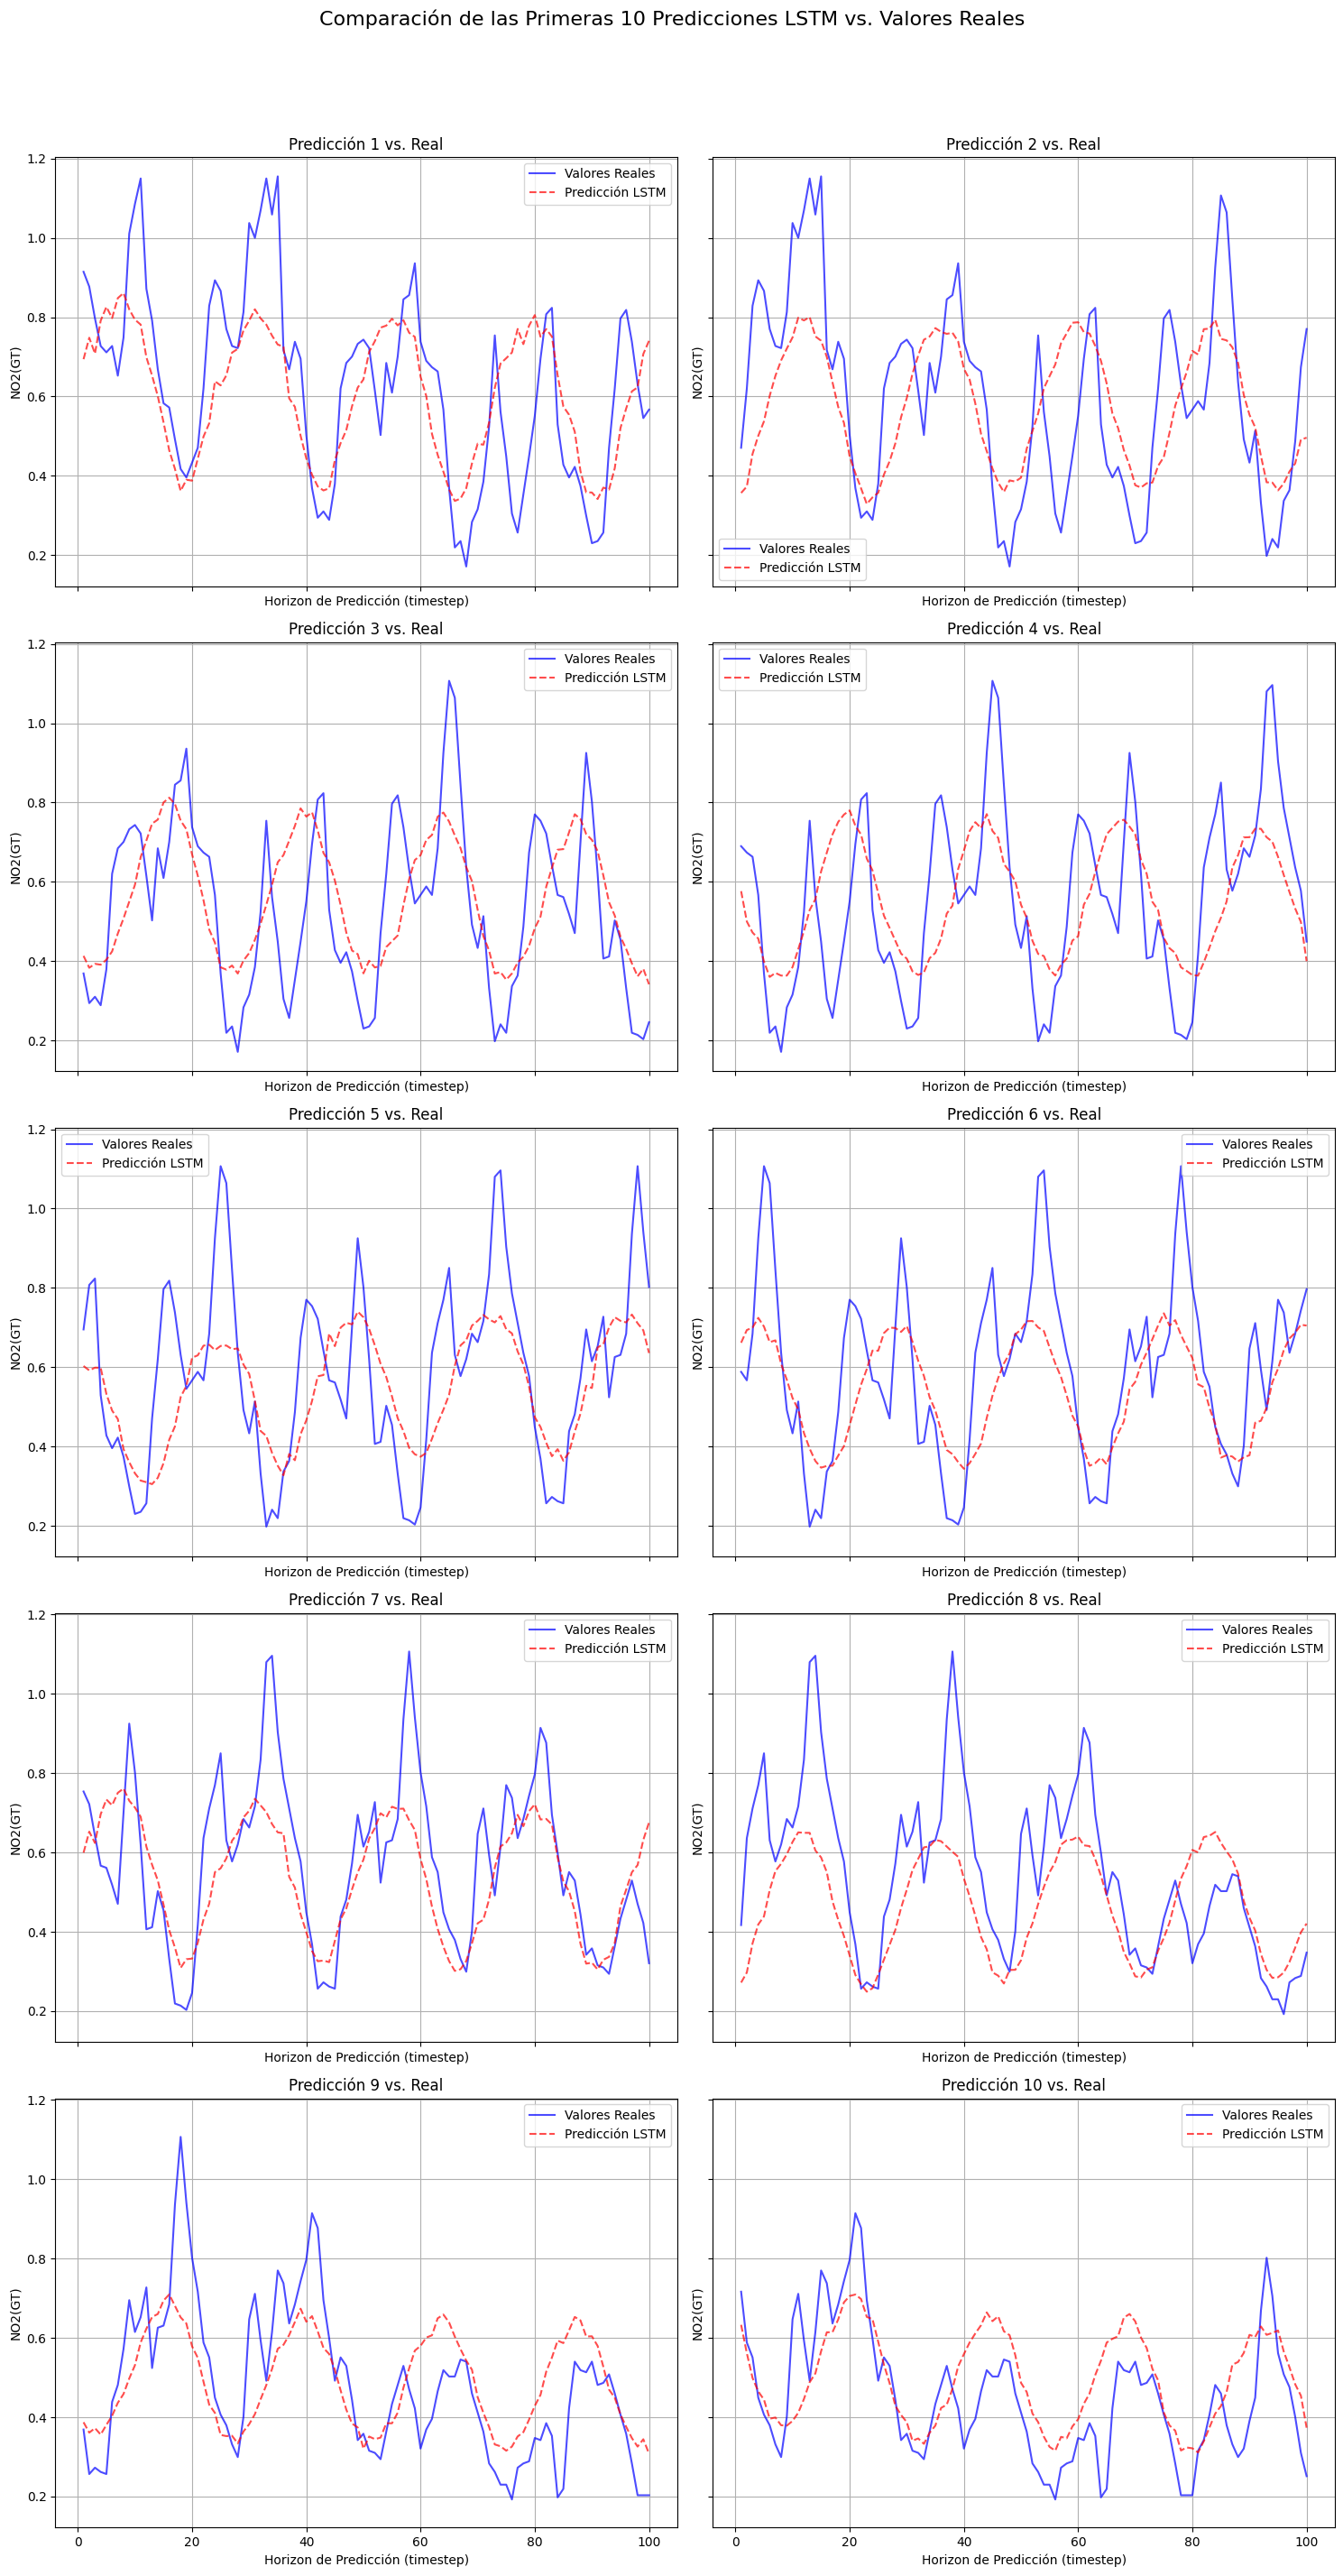

In [ ]:
# Obtain predictions and actual values
lstm_pred = model.predict(X_test)

# Parameters
num_plots = 10  # Number of predictions to be displayed
n_cols = 2
n_rows = (num_plots + 1) // n_cols

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()
forecast_steps = np.arange(1, forecast_horizon + 1)

for i in range(num_plots):
    ax = axes[i]
    predicted = lstm_pred[i * 20]
    actual = y_test[i * 20]
    ax.plot(forecast_steps, actual, label='Actual Values', color='blue', alpha=0.7)
    ax.plot(forecast_steps, predicted, label='LSTM Forecast', color='red', linestyle='--', alpha=0.7)
    ax.set_xlabel('Forecast Horizon (timestep)')
    ax.set_ylabel('NO2(GT)')
    ax.set_title(f'Prediction {i+1} vs. Actual')
    ax.legend()
    ax.grid(True)

# Remove empty axes if num_plots does not completely fill the grid
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Comparison of {num_plots} LSTM Predictions vs. Actual Values', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Model Evaluation and Error Analysis**

This section evaluates the LSTM model's performance and analyzes prediction errors:

- **Performance Metrics**:
  - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions.
  - **Mean Squared Error (MSE)**: Indicates the average squared difference between actual and predicted values.
  - **Root Mean Squared Error (RMSE)**: Provides the standard deviation of prediction errors.
  - **Mean Absolute Percentage Error (MAPE)**: Expresses prediction accuracy as a percentage.
  - **R² Score**: Reflects the proportion of variance explained by the model.

- **Error Distribution**:
  - A histogram displays the distribution of prediction errors, with a kernel density estimate overlay to visualize the error spread.

- **Error Over Time**:
  - A line plot shows how prediction errors vary over time, helping identify patterns or trends in model performance. 

These analyses provide insights into the model's accuracy and areas for potential improvement.

In [146]:
# Aplanar las predicciones y los valores reales para cálculo de métricas
mae = mean_absolute_error(y_test.flatten(), lstm_pred.flatten())
rmse = root_mean_squared_error(y_test.flatten(), lstm_pred.flatten())
mse = rmse**2
epsilon = 1e-10
mape = np.mean(np.abs((y_test.flatten() - lstm_pred.flatten()) / (y_test.flatten() + epsilon))) * 100  # Para MAPE, evitar divisiones por cero
r2 = r2_score(y_test.flatten(), lstm_pred.flatten())

print('Evaluación del Modelo LSTM:')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R² Score: {r2:.4f}')

Evaluación del Modelo LSTM:
Mean Absolute Error (MAE): 0.1319
Mean Squared Error (MSE): 0.0274
Root Mean Squared Error (RMSE): 0.1655
Mean Absolute Percentage Error (MAPE): 36.69%
R² Score: 0.3890


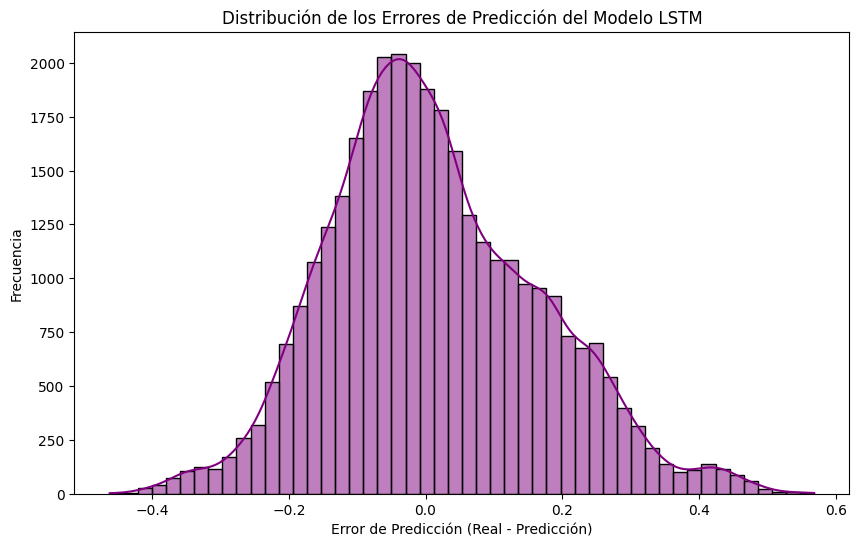

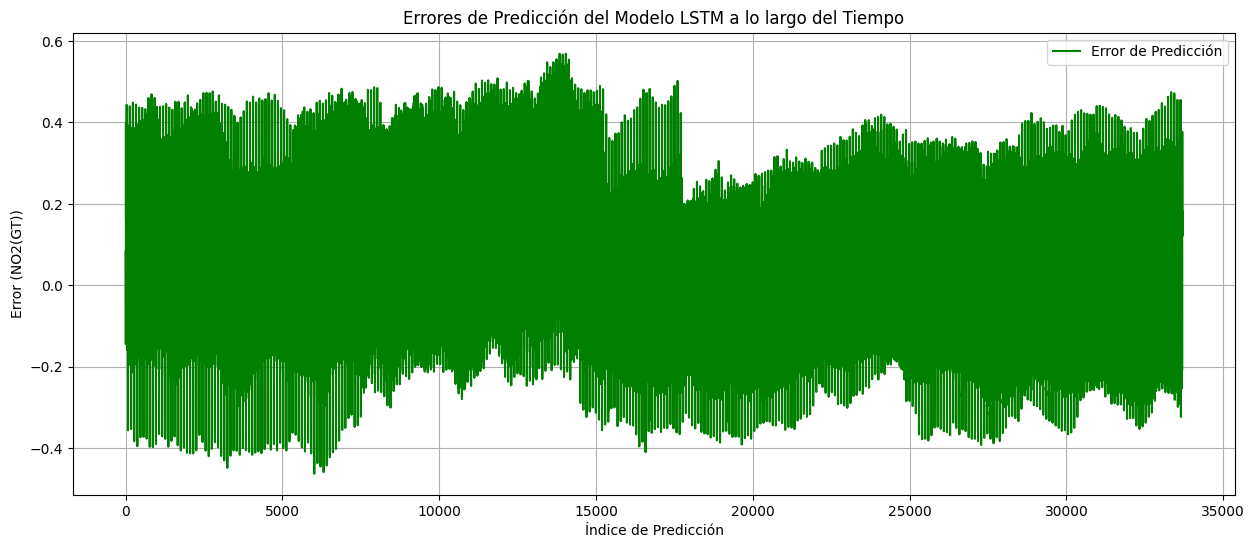

In [138]:
# Calculate errors
errors = y_test - lstm_pred

# Distribution of errors
plt.figure(figsize=(10, 6))
sns.histplot(errors.flatten(), bins=50, kde=True, color='purple')
plt.xlabel('Prediction Error (Actual - Prediction)')
plt.ylabel('Frequency')
plt.title('LSTM Model Prediction Error Distribution')
plt.show()

# Plot of errors over time
plt.figure(figsize=(15, 6))
plt.plot(errors.mean(), label='Prediction Error', color='green')
plt.xlabel('Predictive Index')
plt.ylabel('Error (NO2(GT))')
plt.title('Prediction Errors of the LSTM Model over Time')
plt.legend()
plt.grid(True)
plt.show()

## flake8 linter

Use of flake8 to ensure code quality and adherence to Python's PEP 8 style guide across scripts and Jupyter notebooks.

In [3]:
!cd .. & flake8 ./

In [7]:
!cd .. & nbqa flake8 ./